# A/B Test for E-Commerce

A/B tests are commonly used in industry to test changes on a web page by exposing a control group to the old webpage and a treatment group to the new web page. The level of user engagement can be measured by a selected metric, in this case we use conversion rate.

## Introduction
An e-commerce company has developed a new web page in order to try and increase purchases (conversions) made through their site. They have run an AB experiment and collected data regarding the number of conversions for a control group and a treatment group. The objective of this project is to assess the data and help the company understand if they should implement this new page, keep the old page, or run the experiment longer to make their decision.

We will then implement logistic regression algorithms in order to predict the probability of a individual users purchasing products from their site.

## Data Overview
The datasets for this project are provided by **Udacity** in association with their **Data Analyst Nanodegree** programme. They have been generated to represent example A/B experiment results from an e-commerce website. There are 2 raw csv files:

  * `ab_test.csv` - contains information regarding the group (control or treatment), landing page (old or new), timestamp of visit and conversion.
  * `countries.csv` - contains information regarding the country of origin of each user.

In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import os
import sys
import statsmodels.api as sm

%matplotlib inline

path = os.path.abspath(os.path.join('../features'))
if path not in sys.path:
    sys.path.append(path)

# Custom libraries
import visualise as vis

# Seed random to keep values common for each execution
np.random.seed(42)

In [3]:
df_ab = pd.read_csv('../data/ab_data.csv')
df_country = pd.read_csv('../data/countries.csv')

## Data Assessment

In [4]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


* No null values in any column
* Timestamp is object not datetime

In [6]:
df_ab.user_id.duplicated().sum(), df_ab.duplicated().sum()

(3894, 0)

* There are 3894 duplicate `user_id`'s who have visited more than once.
* None of the rows are duplicated

In [7]:
df_ab[df_ab.user_id.duplicated(keep=False)].sort_values(by='user_id').head(10)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
96929,630471,2017-01-07 02:14:17.405726,control,new_page,0
110634,630471,2017-01-23 01:42:51.501851,control,old_page,0


In [8]:
print("Rows misaligned:", (((df_ab.group == "control")&(df_ab.landing_page != "old_page"))|\
        ((df_ab.group == "treatment")&(df_ab.landing_page != "new_page"))).sum())

Rows misaligned: 3893


* There are 3893 rows with mismatched `group` and `landing_page` variables where:
    * `control != old_page` OR `treatment != new_page`

In [9]:
df = df_ab[(((df_ab.group == "control")&(df_ab.landing_page == "old_page"))|\
        ((df_ab.group == "treatment")&(df_ab.landing_page == "new_page")))]

df[df.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


* There is only one duplicated `user_id` in the sample whcih does not have mismatched `group` and `landing_page`. * They were exposed to the new page twice and converted neither times.

In [10]:
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


* `df_country` contains the `user_id` and `country` information. 
* `user_id` is a primary key we can merge the dataframes on

In [11]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [12]:
df_ab.user_id.nunique(), df_country.user_id.nunique()

(290584, 290584)

* There number of unique `user_id`'s in each dataframe are equal.
* There are no duplicated `user_id`'s in `df_country`

### Assessment Summary
* No null values in any column
* Timestamp is object not datetime
* There are 3894 duplicate `user_id`'s who have visited more than once.
* None of the rows are duplicated
* There are 3893 rows with mismatched `group` and `landing_page` variables where:
    * `control != old_page` OR `treatment != new_page`
* There is only one duplicated `user_id` in the sample whcih does not have mismatched `group` and `landing_page`.
* There number of unique `user_id`'s in each dataframe are equal.
* There are no duplicated `user_id`'s in `df_country`
***
### Define Fixes
* Convert `timestamp` to datetime
* Drop rows with misaligned `group` and `landing_page` variables
* Drop one instance of the remaining duplicated `user_id` to ensure conversion rates apply to only unique users.
* Merge `country` from `df_country` into `df_ab`
***
### Code & Test

In [13]:
## Create copy of df_ab
df_clean = df_ab.copy()

In [14]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [15]:
## Remove misalgined group and landing pages
df_clean = df_ab[(((df_ab.group == "control")&(df_ab.landing_page == "old_page"))|\
                ((df_ab.group == "treatment")&(df_ab.landing_page == "new_page")))]

assert all(df_clean[df_clean.group == "control"].landing_page == 'old_page')
assert all(df_clean[df_clean.group == "treatment"].landing_page == 'new_page')

In [16]:
## Drop duplicated user_id
df_clean = df_clean[~df_clean.user_id.duplicated()]

assert not all(df_clean.user_id.duplicated())

In [17]:
df_clean = df_clean.merge(df_country, on='user_id', how='left')
df_clean.to_csv('../data/ab_data_clean.csv', index=False)
df_clean.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


We have addressed all of the issues raised and are now ready to analyse the dataset.

## Analysis of A/B Test Results

The metric we'll use to assess the performance of each page is click through rate (CTR) which describes the proportion of uses who converted. Lets construct our null and alternative hypothesese:

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

Given the hypotheses, we will accept a type I error tolerance of: $$\alpha \leq 5\%$$
***
Lets separate out out treatment and control groups into two new dataframes and calculate the proportions of users converted.

In [12]:
# Construct df's for each group
df_clean = pd.read_csv('../data/ab_data_clean.csv')
df_new = df_clean[df_clean.landing_page=="new_page"]
df_old = df_clean[df_clean.landing_page=="old_page"]

In [4]:
print("p_total: ", df_clean.converted.mean())
print("p_new: ", df_new.converted.mean())
print("p_old: ", df_old.converted.mean())
print("p_new - p_old: ", df_new.converted.mean() - df_old.converted.mean())

p_total:  0.11959708724499628
p_new:  0.11880806551510564
p_old:  0.1203863045004612
p_new - p_old:  -0.0015782389853555567


This initial assessment suggests that the proportion of users who converted is marginally larger (0.16%) for those exposed to the old page than the new page and therefore we cannot reject the null. 

To give this assessment statistical significance lets create a sample distribution for the difference in conversion rates through bootstrapping.

In [20]:
start = datetime.now()
diffs=[]
for _ in range(10000):
    boot_new = np.random.choice(df_new.converted, df_new.shape[0], replace=True)
    boot_old = np.random.choice(df_old.converted, df_old.shape[0], replace=True)
    diffs.append(np.mean(boot_new)-np.mean(boot_old))
    
end = datetime.now()
runtime = end - start
print(runtime)

0:01:20.976550


/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


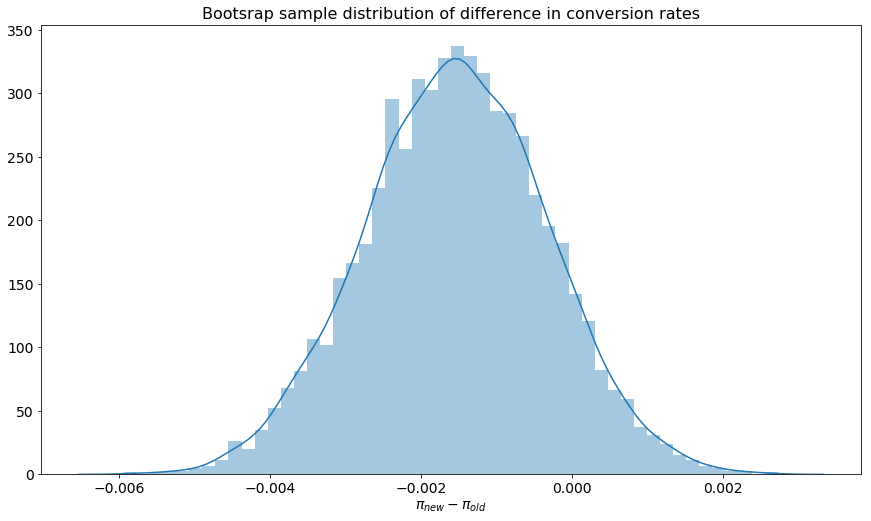

In [21]:
vis.createPlot()
sb.distplot(diffs);
plt.title("Bootsrap sample distribution of difference in conversion rates", fontsize=16);
plt.xlabel("$\pi_{new} - \pi_{old}$");

We can simulate the sampling distributions using an alternative method which avoids the use of a computationally expensive for loop by generating binomial distrubutions using the sample means as probability of conversion.

/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


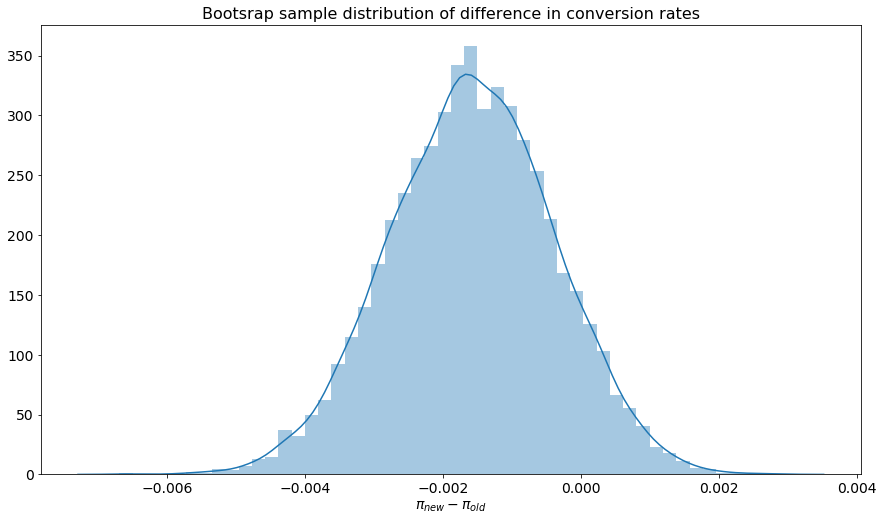

In [5]:
start = datetime.now()
p_new = np.random.binomial(df_new.shape[0], df_new.converted.mean(),10000)/df_new.shape[0]
p_old = np.random.binomial(df_old.shape[0], df_old.converted.mean(),10000)/df_old.shape[0]
p_diffs = p_new - p_old

end = datetime.now()

vis.createPlot()
sb.distplot(p_diffs);
plt.title("Bootsrap sample distribution of difference in conversion rates", fontsize=16);
plt.xlabel("$\pi_{new} - \pi_{old}$");

runtime2 = end - start

In [23]:
print("Loop runtime:", runtime)
print("Binomial runtime:", runtime2)
print("Delta:", runtime - runtime2)

Loop runtime: 0:01:20.976550
Binomial runtime: 0:00:00.003592
Delta: 0:01:20.972958


There is a huge difference in runtime speeds between the 2 methods used. The initial mehtod which made us of a for loop computes in 1 minute 20 seconds on my computer, whilst the method which uses a normalised binomial distribution computes in 3 millseconds.

We can use the standard deviation of sampling distribution `p_diffs` to generate a distribution from the null then caluclate the p-value.

std 0.0011897556906473163


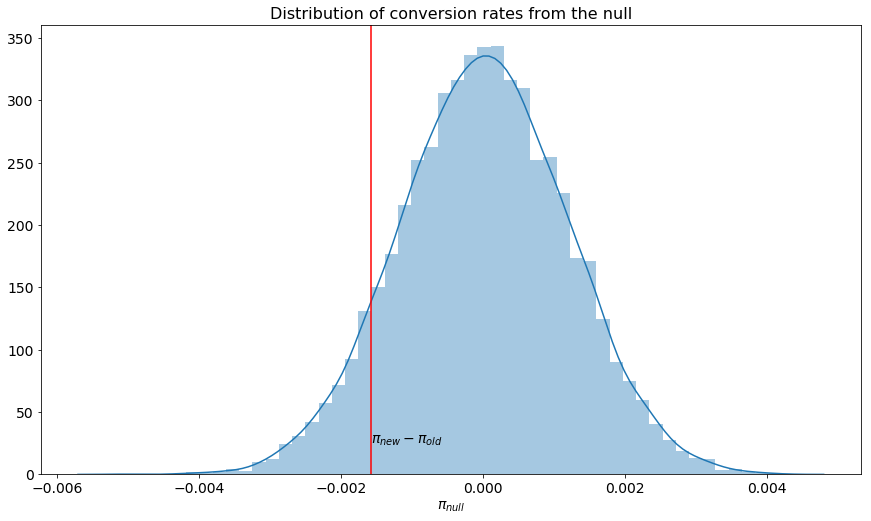

In [6]:
print("std", np.std(p_diffs))
nulls = np.random.normal(0, np.std(p_diffs), 10000)

vis.createPlot();
sb.distplot(nulls);
plt.title("Distribution of conversion rates from the null", fontsize=16);
plt.xlabel("$\pi_{null}$", fontsize=14);
plt.axvline(np.mean(p_diffs), color='r');
plt.text(np.mean(p_diffs), 25, "$\pi_{new} - \pi_{old}$", rotation=0, fontweight='bold', fontsize=14);

In [7]:
p_val = (nulls > np.mean(p_diffs)).mean()
print("p-value:", p_val)

p-value: 0.9105


### Interpretation
The p-value of 0.9099 tells us that the probability of observing our value for $\pi_{new}-\pi_{old}$, or one that favours the alternative more strongly is 91%, given that the null is true. Specifically: $$ P(\pi_{diff}\geq-0.15|H_0=True) = 0.91$$

Given a target tolerance for type I error rate of: $\alpha \leq 5\%$, we fail to reject the null hypothesis. 

Viewing the problem differently, we can construct the following hypotheses:

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} < 0$$

The null hypothesis remains centred around 0 but we have switched the alternative hypothesis. Using the same distribution of conversion rates from the null hypothesis we can recalculate the p-value for the new set of hypothesese: $p = 0.0901$. This tells us that the probability of observing our value for $\pi_{new}-\pi_{old}$, or one that favours the alternative more strongly, is 9% given that the null is true: 
$$ P(\pi_{diff}\leq-0.15|H_0=True) = 0.09$$

We could reject the null based on a type 1 error rate of 10% but fail to reject the null on a type 1 error rate of 10%. Therefore, we can only state with 90% confidence that the new page performs **worse** than the old page in terms of user conversion rate. 

Practically, it is possible that the reduction in purchases on the new page is a result of _change aversion behaviour_ of the users. Lets view the conversion rates across the full time period of the experiment to determine if continuing the experiment for a longer period of time would be worth while.

In [5]:
# Extract day data from timestamp
df_new.timestamp = pd.to_datetime(df_new.timestamp)
df_new['day'] = df_new.timestamp.dt.day

df_old.timestamp = pd.to_datetime(df_old.timestamp)
df_old['day'] = df_old.timestamp.dt.day


/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

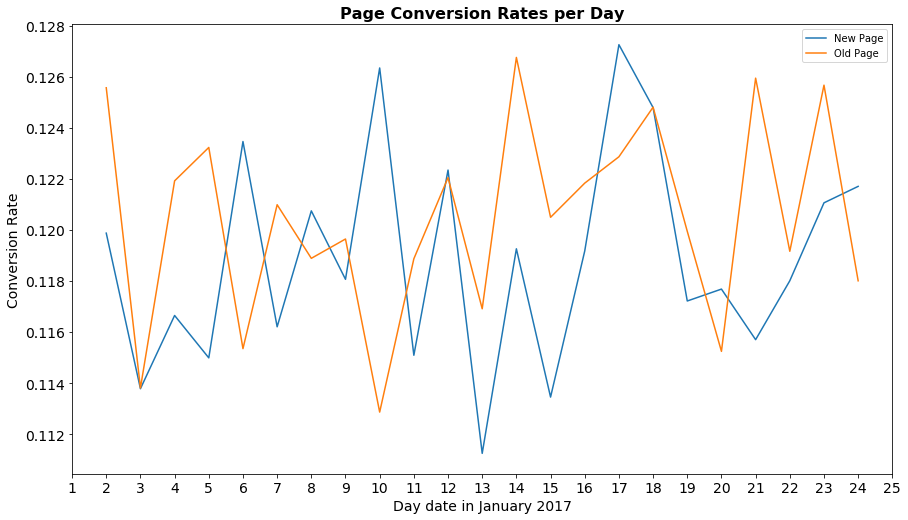

In [9]:
vis.createPlot()
sb.lineplot(data=df_new, x='day', y='converted', ci=None);
sb.lineplot(data=df_old, x='day', y='converted', ci=None);
plt.title("Page Conversion Rates per Day", fontsize=16, fontweight='bold');
plt.xlabel("Day date in January 2017");
plt.ylabel("Conversion Rate");
plt.xlim(1,25),
plt.xticks(np.arange(1,26,1));

import matplotlib.lines as mlines

l0 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[0])
l1 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[1])

plt.legend((l0,l1), ("New Page", "Old Page"));

There is a great deal of noise in the timeseries plot which potentially hides trends within the data. Lets compute a 5 day rolling average conversion rate for each series.

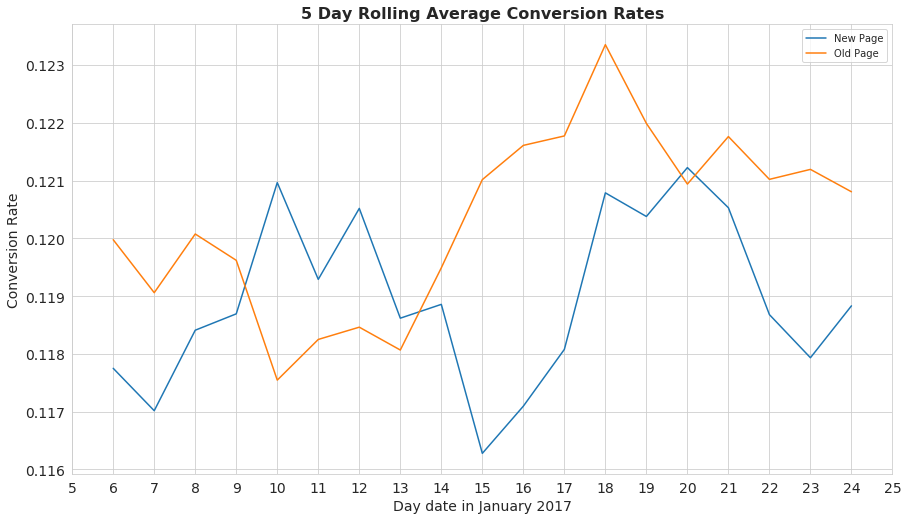

In [17]:
# Rolling Averages
series1 = df_new.groupby('day').mean().rolling(5).mean()
series2 = df_old.groupby('day').mean().rolling(5).mean()

sb.set_style('whitegrid')

vis.createPlot()
sb.lineplot(data=series1, x=series1.index, y='converted', ci=None);
sb.lineplot(data=series2, x=series2.index, y='converted', ci=None);


plt.title("5 Day Rolling Average Conversion Rates", fontsize=16, fontweight='bold');
plt.xlabel("Day date in January 2017");
plt.ylabel("Conversion Rate");
plt.xlim(5,25);
plt.xticks(np.arange(5,26,1));


l0 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[0])
l1 = mlines.Line2D([],[],linestyle='-', color=sb.color_palette()[1])

plt.legend((l0,l1), ("New Page", "Old Page"));

Computing the 5 day rolling average reduces the noise in the data. In general, the conversion rates for the new and old pages fluctuate around each other, with the old page performing better in the second half of the experiment timeframe. The rolling averages between 15th-17th have the largest delta in conversion rates, with the old page seeing a conversion rate betweeen 0.04-0.05 greater than the new page. This equates to an absolute difference of around 5000-7000 purchases a day. It is possible that this is a product of change aversion behaviour, however, with a p-value of 0.9, even without this difference we are unlikely to reject the null hypothesis by gathering more data over a longer period.

## Conclusion

Based on a type 1 error rate threshold of 5%, we cannot state with statsitcal significance that the new page performs differently to the old page. We could only state with 90% confidence that the new page stimulates less purchases than the old page. My recommendation to the e-commerce site would be to not deploy the new page and do not continue to run the A/B experiment.

## Logistic Regression Assessment
Another approach we can take to assess the conversion rates is to build a logistic regression model. We will do this initially using the `statsmodels api` then build our own logistic regression model in [this](http://localhost:8888/notebooks/DAND/AB_Test/notebooks/Logistic_Regression_Model.ipynb) notebook.

In [18]:
df_log = df_clean.copy()

# Extract day information from timestamp
df_log.timestamp = pd.to_datetime(df_log.timestamp)
df_log['day'] = df_log.timestamp.dt.day
df_log['hour'] = df_log.timestamp.dt.hour


# Create intercept
df_log['intercept'] = 1

# Create dummy variables for country and web_page
df_log[['CA', 'UK','US']] = pd.get_dummies(df_log['country'])
df_log['landing_page'] = np.where(df_log.landing_page == 'old_page', 0, 1)

# Make UK our baseline feature
df_log.drop('UK', axis=1, inplace=True)
df_log.head()

,user_id,timestamp,group,landing_page,converted,country,day,hour,intercept,CA,US
0,851104,2017-01-21 22:11:48.556739,control,0,0,US,21,22,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,0,0,US,12,8,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,1,0,US,11,16,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,1,0,US,8,18,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,0,1,US,21,1,1,0,1


In [19]:
# Instantiate and run model 
mod = sm.Logit(df_log.converted, df_log.loc[:, ['intercept', 'landing_page', 'CA', 'US', 'day', 'hour']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366096
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 09 Sep 2019   Pseudo R-squ.:               6.930e-05
Time:                        17:53:46   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.01151
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -2.0251      0.020   -100.324      0.000      -2.065      -1.986
landing_page    -0.0149      0.011     -1.302      0.193      -0.037       0.008
CA              -0.0506      0.028     -1.783      0.075      -0.106       0.005
US              -0.0101      0.013     -0.757      0.449      -0.036       0.016
day              0.0015      0.001      1.637      0.102      -0.000       0.003
hour             0.0023      0.001      2.771      0.006       0.001       0.004
================================================================================
"""

The results tell us the following:
* Users receiving the treatment landing page are 1.5% less likely to convert
* Users from Canada and the US are 5% and 1% less likely to covert than users from the UK
* The day or hour in which a user visits the website has less than 1% of an effect on user conversion rates
* The only feature which is statistically significant for prediction is the `hour` in which the page was visited.